In [ ]:
!pip install opacus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 14.0 MB/s eta 0:00:00


In [ ]:
from opacus import PrivacyEngine

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 10)
        # self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # self.conv2_drop = nn.Dropout2d()
        # self.fc1 = nn.Linear(320, 50)
        # self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
        # x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # x = x.view(-1, 320)
        # x = F.relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        # x = self.fc2(x)
        # return F.log_softmax(x)


In [ ]:

# IID case: all the clients have images of all the classes

# Hyperparameters

num_clients = 10
num_selected = 5
Epoch = 1
iter_per_client = 10
batch_size = 32

pre_delta=1e-5
momentum=0.5
pre_lr=1e-2
EPSILON = 50.0

MAX_GRAD=1.5
NOISE_MUL=1.5

In [ ]:
def client_update(client_model, optimizer, train_loader, privacy_engine, epoch=5, delta=1e-5):
    model.train()
    criterion = nn.CrossEntropyLoss()

    for e in range(epoch):
        losses = []
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to("cuda")
            target = target.to("cuda")

            optimizer.zero_grad()

            output = client_model(data)
            loss = criterion(output, target)

            loss.backward()
            optimizer.step()

            losses.append(loss.item()) ###########

    epsilon = privacy_engine.get_epsilon(delta)
    print(f"[client_i]\t"
                  f"Train Epoch: {e} \t"
                  f"Loss: {sum(losses)/len(losses):.4f} "
                  f"(ε = {epsilon}, δ = {delta})")
    # print('Epsilon={}'.format(epsilon))

    return loss.item(), epsilon

In [ ]:
def server_aggregate(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k] for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

In [ ]:
def test(global_model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = global_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    return test_loss, acc

In [ ]:
# Creating decentralized datasets
# download dataset
traindata = datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
                       )

# split dataset
traindata_split = torch.utils.data.random_split(traindata, [int(traindata.data.shape[0] / num_clients) for _ in range(num_clients)])
# train_loaders
train_loader_ls = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
        ), batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 388554417.66it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 78864384.00it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 85544014.50it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 15692363.07it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
client_models, optimizers, DP_dataloader_ls, privacy_engine_ls = [], [], [], []

for client in range(num_clients):
    model=Net().to("cuda")

    optimizer = optim.RMSprop(model.parameters(), lr=pre_lr)

    data=train_loader_ls[client]

    privacy_engine = PrivacyEngine()
    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=data,
        epochs=iter_per_client,
        target_epsilon=EPSILON,
        target_delta=pre_delta,
        max_grad_norm=MAX_GRAD,
    )

    client_models.append(model)
    # dataloaders.append(dataloader)
    optimizers.append(optimizer)
    privacy_engine_ls.append(privacy_engine)
    DP_dataloader_ls.append(train_loader)
    # print(f"Using sigma={optimizer.noise_multiplier} and C={MAX_GRAD}")

In [ ]:
# Instantiate models and optimizers

global_model = client_models[0]

# client_models = [Net().cuda() for _ in range(num_selected)]
# for model in client_models:
#     model_params=global_model.state_dict()
#     model.load_state_dict(model_params)

# opt = [optim.SGD(model.parameters(), lr=0.1) for model in client_models]

# Runnining FL
test_acc, test_losses, epsilon = [], [], []

for r in range(Epoch):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]

    # client update
    loss = 0
    eps_ls=[]
    for i in range(num_selected):
        loss, eps= client_update(client_models[client_idx[i]], optimizers[client_idx[i]], DP_dataloader_ls[client_idx[i]], privacy_engine_ls[client_idx[i]], epoch=iter_per_client, delta=pre_delta)

        loss+=loss
        eps_ls.append(eps)

    # serer aggregate
    server_aggregate(global_model, client_models)
    test_loss, acc = test(global_model, test_loader)

    test_acc.append(acc)
    test_losses.append(test_loss)
    epsilon.append(max(eps_ls))
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f | epsilon: %0.3f' % (loss / num_selected, test_loss, acc, max(eps_ls)))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


[client_i]	Train Epoch: 9 	Loss: 13.8593 (ε = 49.99978082381756, δ = 1e-05)
[client_i]	Train Epoch: 9 	Loss: 6.4790 (ε = 49.99978082381756, δ = 1e-05)
[client_i]	Train Epoch: 9 	Loss: 7.7398 (ε = 49.99978082381756, δ = 1e-05)
[client_i]	Train Epoch: 9 	Loss: 7.6047 (ε = 49.99978082381756, δ = 1e-05)
[client_i]	Train Epoch: 9 	Loss: 11.6412 (ε = 49.99978082381756, δ = 1e-05)
0-th round
average train loss 5.06 | test loss 2.31 | test acc: 0.061 | epsilon: 50.000


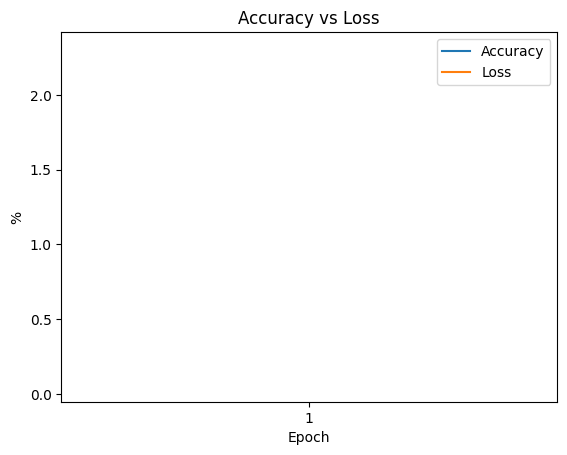

In [ ]:
from pylab import plt
x = [i+1 for i in range(Epoch)]
plt.plot(x,test_acc,label='Accuracy')
plt.plot(x,test_losses,label='Loss')
plt.title("Accuracy vs Loss")
plt.xlabel('Epoch')
plt.ylabel('%')
plt.xticks(x)
plt.legend()
plt.show()
# plt.savefig()